##### PROJECT: Does Flexible Cancellation Policy Improve Customer Satisfaction?

**Goal:** Estimate the causal effect of flexible cancellation policies on customer satisfaction.  
**Methods:** Propensity Score Matching (PSM), Inverse Probability Weighting (IPW)

In [1]:
import pandas as pd
import numpy as np

print("Jupyter is ready!")

Jupyter is ready!


In [2]:
# Load a CSV file (replace with your file path)
df = pd.read_csv('raw_cancelpolicy_satisfaction.csv')

# Take a quick look at the data
df.head()

,BOOKING_PROCESS_ID,BOOKING_DATE,STAY_DURATION,TRIP_TYPE,LEAD_TIME,TOTAL_SPEND,BOOKING_RATE_TYPE,ROOM_TYPE,HOTEL_ROOM_CATEGORY,SATISFACTION_SCORE,FLEXIBLE_POLICY
0,167385268,2023-10-17,1,1,56,74.086,Negotiated Rate,Single,Standard,8.250000,1
1,177872630,2024-12-16,2,1,57,208.000,Negotiated Rate,Single,Standard,8.000000,1
2,147885361,2021-10-05,1,1,7,79.000,Negotiated Rate,Single,Standard,8.545455,1
3,145135965,2021-05-16,2,1,1,101.496,Negotiated Rate,Single,Standard,9.600000,1
4,153120091,2022-06-13,1,1,1,50.557,Negotiated Rate,Single,Standard,10.000000,1


In [3]:
# Check for missing values
df.isnull().sum()

# Summarize the data
df.describe()

,BOOKING_PROCESS_ID,STAY_DURATION,TRIP_TYPE,LEAD_TIME,TOTAL_SPEND,SATISFACTION_SCORE,FLEXIBLE_POLICY
count,9.822980e+05,982298.000000,982298.000000,982298.000000,982298.000000,982298.000000,982298.000000
mean,1.561051e+08,2.101342,0.271550,25.306580,223.564940,8.206446,0.032189
std,1.198215e+07,2.347090,0.482654,43.366068,314.964011,1.594319,0.176501
min,1.369028e+08,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,1.459170e+08,1.000000,0.000000,3.000000,85.050000,7.636364,0.000000
50%,1.541955e+08,1.000000,0.000000,9.000000,132.000000,8.600000,0.000000
75%,1.670033e+08,2.000000,1.000000,28.000000,256.419500,9.300000,0.000000
max,1.795545e+08,99.000000,2.000000,1168.000000,64000.000000,10.000000,1.000000


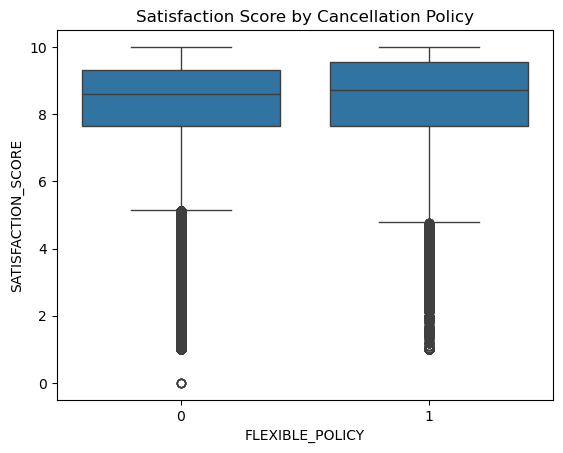

In [4]:
# Visualise relationship between satisfaction_score and flexible_policy
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='FLEXIBLE_POLICY', y='SATISFACTION_SCORE')
plt.title('Satisfaction Score by Cancellation Policy')
plt.show()


A quick glance tells us that having flexible cancellation policies does not influence traveller satisfaction, without considering confounders.

#### Check for potential confounders - understand what could bias results. Examples:
- Do customers with longer stays choose flexible policies more often?
- Are higher-paying customers more likely to choose flexible policies?

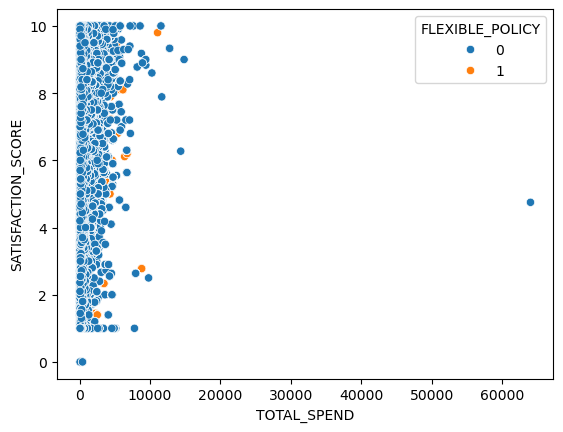

In [5]:
#Lead time:
#sns.scatterplot(x='LEAD_TIME', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
#plt.show();

#Trip type (business/leisure)
#sns.scatterplot(x='TRIP_TYPE', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
#plt.show();

#Booking rate type:
#sns.scatterplot(x='BOOKING_RATE_TYPE', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
#plt.show();

#Room type:
#sns.scatterplot(x='ROOM_TYPE', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
#plt.show();

#Hotel room category:
#sns.scatterplot(x='HOTEL_ROOM_CATEGORY', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
#plt.show();

#Total spend:
sns.scatterplot(x='TOTAL_SPEND', y='SATISFACTION_SCORE', hue='FLEXIBLE_POLICY', data=df)
plt.show();

None of the columns seem to have an obvious correlation with Satisfaction. 
In fact, column Hotel Room Category can be dropped, since little value can be derived from this column.

In [6]:
df = df.drop('HOTEL_ROOM_CATEGORY', axis=1)

df.describe()

,BOOKING_PROCESS_ID,STAY_DURATION,TRIP_TYPE,LEAD_TIME,TOTAL_SPEND,SATISFACTION_SCORE,FLEXIBLE_POLICY
count,9.822980e+05,982298.000000,982298.000000,982298.000000,982298.000000,982298.000000,982298.000000
mean,1.561051e+08,2.101342,0.271550,25.306580,223.564940,8.206446,0.032189
std,1.198215e+07,2.347090,0.482654,43.366068,314.964011,1.594319,0.176501
min,1.369028e+08,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,1.459170e+08,1.000000,0.000000,3.000000,85.050000,7.636364,0.000000
50%,1.541955e+08,1.000000,0.000000,9.000000,132.000000,8.600000,0.000000
75%,1.670033e+08,2.000000,1.000000,28.000000,256.419500,9.300000,0.000000
max,1.795545e+08,99.000000,2.000000,1168.000000,64000.000000,10.000000,1.000000


###### BUILDING PROPENSITY MODELS

#### METHOD 1: Propensity Score Matching (PSM)
PSM matches customers with similar likelihoods of choosing a flexible policy and compares their satisfaction scores.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances


### Treatment and outcome
X = df[['STAY_DURATION', 'LEAD_TIME', 'TRIP_TYPE', 'TOTAL_SPEND']]  # Covariates
y = df['FLEXIBLE_POLICY']  # Treatment
outcome = df['SATISFACTION_SCORE']
# X: These are covariates — the characteristics that might influence both the treatment (choosing flexible policy) and the outcome (satisfaction).
# y: This is the treatment variable — whether the customer chose a flexible policy (1) or not (0).
# outcome: This is what we want to measure the impact on — customer satisfaction.

### One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Some columns (like TRIP_TYPE) may be categorical, so we convert them into numerical “dummy” variables — e.g., Business or Leisure turns into 0 and 1.
# drop_first=True avoids dummy variable trap (multicollinearity) by dropping one category. Dummy variable trap occurs when one variable can be 
# predicted from the others, making it difficult to interpret predicted coefficient variables in regression models

### Fit logistic regression to estimate propensity scores
lr = LogisticRegression()
lr.fit(X, y)
df['PROPENSITY_SCORE'] = lr.predict_proba(X)[:, 1]
# We’re building a logistic regression model to predict the probability of choosing the flexible policy (y) based on the customer’s characteristics (X).
# predict_proba(X)[:, 1] gives the probability of being in the flexible policy group (1) — this is the propensity score.
# We save this score in a new column PROPENSITY_SCORE in the dataframe.

### Match on propensity scores
treated = df[df['FLEXIBLE_POLICY'] == 1]
control = df[df['FLEXIBLE_POLICY'] == 0]
# treated: All customers who chose flexible policy (1).
# control: All customers who didn’t choose flexible policy (0).

### Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['PROPENSITY_SCORE']])
distances, indices = nn.kneighbors(treated[['PROPENSITY_SCORE']])
# NearestNeighbors(n_neighbors=1): This tells the model to find the single closest match (1 nearest neighbor) for each treated customer.
# fit(control[['PROPENSITY_SCORE']]): We’re telling the model to look for matches from the control group based on their propensity scores.
# kneighbors() finds the closest control customer for each treated customer based on their propensity score.
# distances: How far apart the scores are between the treated customer and their matched control.
# indices: The row numbers of the control group customers that were matched.

### Matched control group
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)
# matched_control: The control customers who were matched to treated customers.
# matched_treated: The treated customers, aligned to their matched control group.
# Now we have paired similar customers based on their likelihood of choosing the flexible policy — so the only major difference between them 
# should be whether they actually chose the flexible policy. This makes it easier to isolate the impact of the policy on satisfaction.
## Note: more details on the code breakdown below

### Estimate treatment effect
treatment_effect = (matched_treated['SATISFACTION_SCORE'] - matched_control['SATISFACTION_SCORE']).mean()
print(f"Estimated treatment effect (PSM): {treatment_effect}")


Estimated treatment effect (PSM): 0.25668532061671784


A treatment effect of 0.256685 means that, on average, customers who were given a flexible cancellation policy experienced an increase of 0.256685 units in satisfaction compared to similarly matched customers who did not have this option.

Code breakdown:
"matched_control = control.iloc[indices.flatten()].reset_index(drop=True)"

1. indices: the output of the kneighbors() function.
It’s a 2D array — like [[5], [12], [8]] — where each row shows the index of the nearest neighbor from the control group for each treated customer.
2. indices.flatten():
flatten() turns that 2D array into a 1D list — like [5, 12, 8].
This gives us a simple list of row numbers (indices) of the matched control group customers.
3. control.iloc[indices.flatten()]:
iloc[] is pandas’ index-based selection method.
It uses the list of row numbers from indices.flatten() to select those specific rows from the control group dataframe (control).
So, this pulls out the matched control customers who are the closest propensity score neighbors of the treated customers.
4. reset_index(drop=True):
After selecting the rows, the original row numbers from control remain.
reset_index(drop=True) removes those and resets the row numbers to start from 0, so the treated and control groups line up neatly.

## 1. Covariate balance check — using Standardized Mean Differences:
This is crucial because it tells you whether the treated group (flexible policy) and control group (non-flexible policy) are actually comparable after matching.

In [8]:
def standardized_mean_diff(var, treated, control):
    return abs(treated[var].mean() - control[var].mean()) / np.sqrt(0.5 * (treated[var].var() + control[var].var()))

covariates = ['STAY_DURATION', 'LEAD_TIME', 'TRIP_TYPE', 'TOTAL_SPEND']

for var in covariates:
    smd = standardized_mean_diff(var, matched_treated, matched_control)
    print(f"{var} SMD after matching: {smd:.3f}")

STAY_DURATION SMD after matching: 0.006
LEAD_TIME SMD after matching: 0.036
TRIP_TYPE SMD after matching: 0.002
TOTAL_SPEND SMD after matching: 0.017


Interpretation of covariate balance check:
SMD < 0.1 → Good balance: The treated and control groups are very similar on this covariate.
0.1 ≤ SMD < 0.25 → Acceptable balance: There’s some difference, but it’s still reasonable.
SMD ≥ 0.25 → Poor balance: The groups differ a lot on this covariate — suggesting the matching didn’t work well for this variable.

The closer to 0, the better the balance — and the more confident we can be that any difference in Satisfaction is due to the Flexible Policy and not confounding variables. On the other hand, if some variables are imbalanced, our treatment effect estimate might be biased.

On all 4 covariates, the treated group and control group are comparable after matching.

## 2. Propensity score overlap check

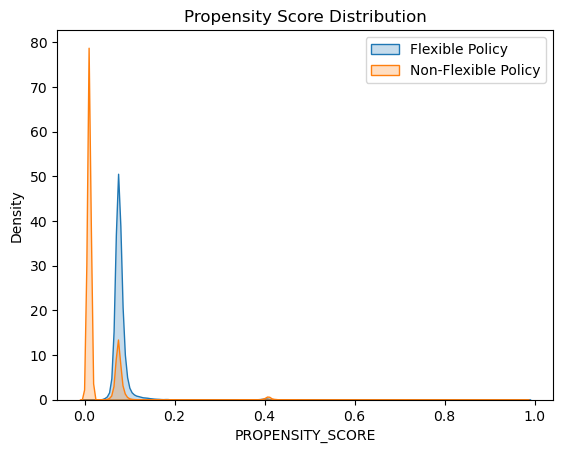

In [9]:
sns.kdeplot(df[df['FLEXIBLE_POLICY'] == 1]['PROPENSITY_SCORE'], label='Flexible Policy', fill=True)
sns.kdeplot(df[df['FLEXIBLE_POLICY'] == 0]['PROPENSITY_SCORE'], label='Non-Flexible Policy', fill=True)
plt.legend()
plt.title('Propensity Score Distribution')
plt.show()

As we can see, the two curves overlap completely where possible.
Meaning: Treated and control groups have many similar customers with similar probabilities of choosing the flexible policy.
Why this is good: Matching works best when there’s enough overlap — you’re comparing apples to apples.

## 3. Statistical significance test

In [10]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(matched_treated['SATISFACTION_SCORE'], matched_control['SATISFACTION_SCORE'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 18.55422094211124, P-value: 1.2057406758377803e-76


A high T-statistic and low p-value means that the result is statistically significant, very low chance that the result is due to random noise.

#### METHOD 2: Inverse Probability Weighting
IPW adjusts for selection bias by weighting observations based on their propensity scores.
We want to know: "Does flexible cancellation improve customer satisfaction?" But we can’t just compare customers who chose flexible vs. non-flexible policies because they’re different kinds of customers — they may have different budgets, stay lengths, or booking lead times.

IPW helps us fix this imbalance by weighting customers so the two groups become more comparable.

How does IPW work?

Propensity score: First, we predict how likely each customer is to choose the flexible policy based on their characteristics (like stay duration, lead time, and total spend). This probability is called the propensity score.
Weights: Then we use the propensity score to adjust the importance of each customer:
    - Customers who chose flexible policy but weren’t very likely to get a higher weight — they’re special cases and more informative.
    - Customers who chose flexible policy and were very likely to get a lower weight — they’re not surprising, so they matter less.
This helps balance the two groups, so any difference in satisfaction is more likely due to the policy, not other factors.

In [11]:
# Step 1: Calculate weights
# If a customer chose the flexible policy, their weight is 1 / their propensity score.
# If they chose the non-flexible policy, their weight is 1 / (1 - their propensity score).
df['ipw'] = np.where(df['FLEXIBLE_POLICY'] == 1, 
                     1 / df['PROPENSITY_SCORE'], 
                     1 / (1 - df['PROPENSITY_SCORE']))

# Step 2: Estimate treatment effect using weighted means
# Weighted mean satisfaction score for those with flexible policy
weighted_flexible = np.average(df[df['FLEXIBLE_POLICY'] == 1]['SATISFACTION_SCORE'], 
                               weights=df[df['FLEXIBLE_POLICY'] == 1]['ipw'])

# Weighted mean satisfaction score for those with non-flexible policy
weighted_non_flexible = np.average(df[df['FLEXIBLE_POLICY'] == 0]['SATISFACTION_SCORE'], 
                                   weights=df[df['FLEXIBLE_POLICY'] == 0]['ipw'])

# Step 3: Calculate the treatment effect
# Difference between the weighted averages of the two groups
treatment_effect_ipw = weighted_flexible - weighted_non_flexible
print(f"Estimated treatment effect using IPW: {treatment_effect_ipw}")

Estimated treatment effect using IPW: 0.08790600035205998


The value 0.0879 suggests that offering a flexible cancellation policy has a positive effect on customer satisfaction. On average, customers who were subject to the flexible cancellation policy reported a 0.0879 unit improvement in their satisfaction compared to what their satisfaction would have been if they did not have access to such a policy.

## 1. ROC-AUC Diagnostics

In [12]:
# 3. Propensity score model diagnostics
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(df['FLEXIBLE_POLICY'], df['PROPENSITY_SCORE'])
print(f"Propensity model ROC-AUC: {roc_auc:.3f}")


Propensity model ROC-AUC: 0.891


In the context of IPW, we want AUC to be good — but not too good.
Why? Because the goal of the propensity score model is to balance the groups, not perfectly predict who chose the flexible policy.
A very high AUC (close to 1.0) means the groups are very different — which can lead to poor overlap and extrapolation.
A moderate AUC (0.7–0.85) is often ideal, suggesting the model captures differences well without over-separating the groups.
Our number is approaching >0.9, but the propensity score overlap graph above suggests we have a good overlap.
Therefore, the ROC-AUC check is good.

## 2. Check stabilized weights
Because unstable weights = unstable estimates, when some weights are too large or too small, they can distort the treatment effect and increase variance. Checking stabilized weights helps ensure the results are reliable.

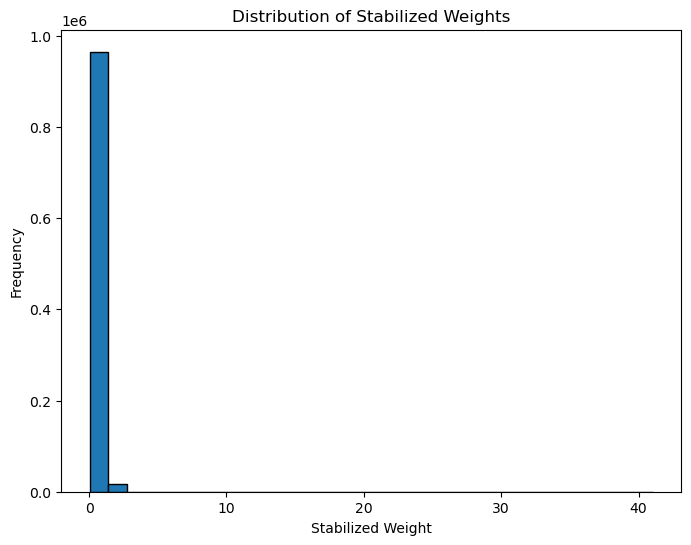

count    982298.000000
mean          0.985344
std           0.165221
min           0.032966
25%           0.976574
50%           0.976908
75%           0.978479
max          41.068823
Name: stabilized_weight, dtype: float64


In [13]:
# Step 2.1: Calculate stabilized weights
p_treatment = df['FLEXIBLE_POLICY'].mean()
df['stabilized_weight'] = np.where(df['FLEXIBLE_POLICY'] == 1,
                                  p_treatment / df['PROPENSITY_SCORE'],
                                  (1 - p_treatment) / (1 - df['PROPENSITY_SCORE']))

# Step 2.2: Check stabilized weight distribution
plt.figure(figsize=(8, 6))
plt.hist(df['stabilized_weight'], bins=30, edgecolor='k')
plt.title('Distribution of Stabilized Weights')
plt.xlabel('Stabilized Weight')
plt.ylabel('Frequency')
plt.show()

# Step 2.3: Summary statistics for stabilized weights
print(df['stabilized_weight'].describe())

Mean weights are close to 1 (generally good if between 0.5 and 2). This means the model is balancing the groups without overemphasizing any single observation.

**Overall, having a flexible cancellation policy does have a positive increase on the satisfaction score, compared to what the score would have been if bookings did not have access to such policy**
- Using Propensity Score Matching method, we arrive at +0.25 satisfaction score for having such a policy
- Using Inverse Probability Weighting, we have +0.0879 satisfaction score for having such a policy
However, the impact, despite being positive, might be neglectable to the travel managers. The question now becomes, 'Is this positive impact worth the cost of having the policy?"